1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# import pandas as pd
# from google.colab import drive
# drive.mount('/content/gdrive')
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler

In [ ]:
# df_src = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/ML_Business/Lesson_4/data.csv')
# df_src.head(5)

In [2]:
df_src = pd.read_csv('data.csv')
df_src.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [3]:
df = df_src.copy()

2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [13]:
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
df.head(10)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0
5,6,134.83,0,1,Surburban,0,Phone,1,1
6,9,280.20,1,0,Surburban,1,Phone,1,0
7,9,46.42,0,1,Urban,0,Phone,1,0
8,9,675.07,1,1,Rural,1,Phone,1,0
9,10,32.84,0,1,Urban,1,Web,1,0


In [5]:
df['treatment'].unique()

array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

In [6]:
df['treatment'].replace({'Buy One Get One': 1, 'Discount': 1,  'No Offer': 0}, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  int64  
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 4.4+ MB


In [9]:
cats = ['zip_code', 'channel']
scale = ['recency', 'history']

3. сделать разбиение набора данных не тренировочную и тестовую выборки

In [10]:
X = df.drop(columns=['target', 'treatment'])
y = df['target']
treat = df['treatment']

In [11]:
X_train, X_test, treat_train, y_test, y_train, treat_test = train_test_split(X, y, treat, random_state=42, test_size=0.33)

4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [15]:
scaling = MinMaxScaler()

In [16]:
X_train[scale] = scaling.fit_transform(X_train[scale])
X_test[scale] = scaling.transform(X_test[scale])

In [17]:
X_train = pd.get_dummies(X_train, prefix_sep="__", columns=cats)
X_test = pd.get_dummies(X_test, prefix_sep="__", columns=cats)

5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

In [20]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier

In [21]:
models_results = {
    'model': [],
    'uplift@10%': [],
    'uplift@20%': []
}

Solo Model

uplift@10%: 0.0695
uplift@20%: 0.0675


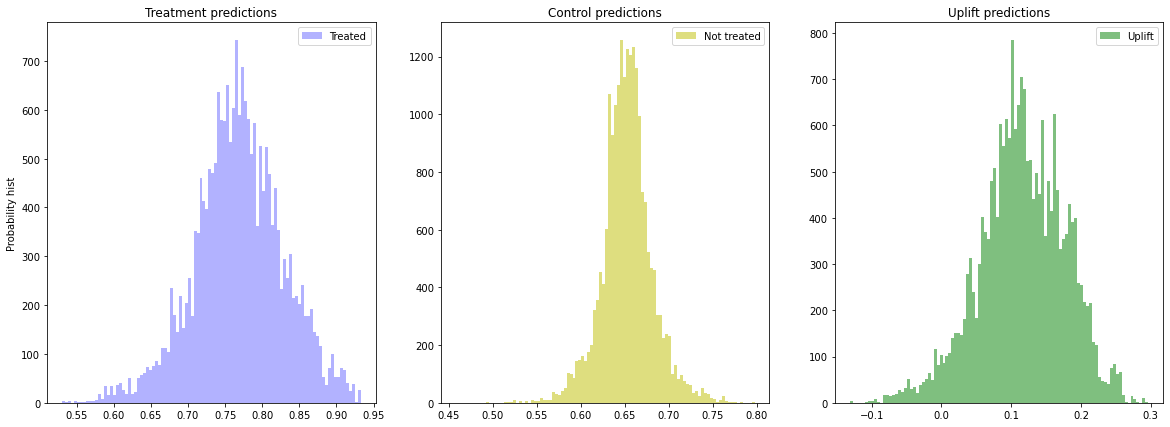

In [22]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)



uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
print(f'uplift@10%: {sm_score_10:.4f}')
print(f'uplift@20%: {sm_score_20:.4f}')


models_results['model'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

sm_trmnt_preds = sm.trmnt_preds_

sm_ctrl_preds = sm.ctrl_preds_

plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

Class Transformation

In [23]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

print(f'uplift@10%: {ct_score_10:.4f}')
print(f'uplift@20%: {ct_score_20:.4f}')


models_results['model'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

<ipython-input-23-80f8e03bb69d>:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train)


uplift@10%: 0.0934
uplift@20%: 0.0864


Two Models

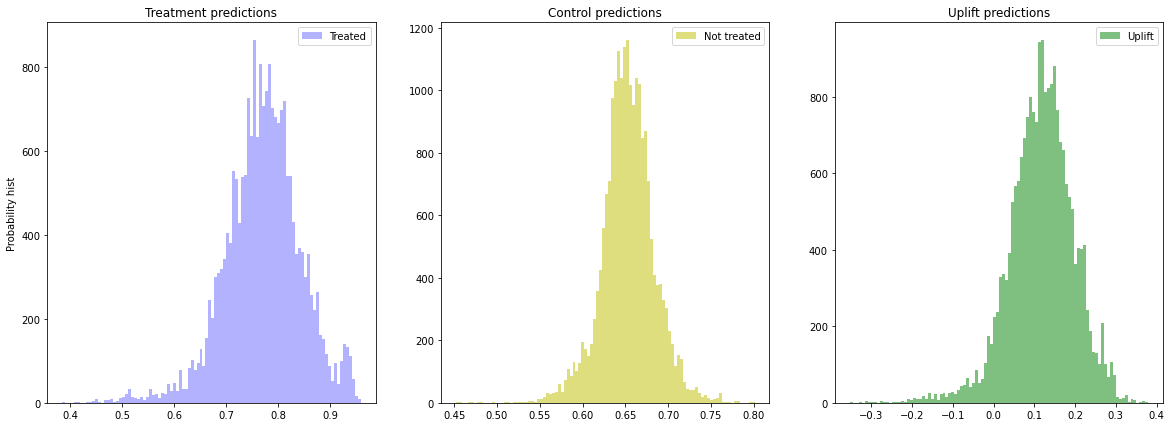

In [25]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True),
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True),
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)


models_results['model'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [26]:
restuls = pd.DataFrame(data=models_results).sort_values('uplift@20%', ascending=False)
restuls

,model,uplift@10%,uplift@20%
1,ClassTransformation,0.093372,0.086383
0,SoloModel,0.069530,0.067485
2,TwoModels,0.055314,0.057229


7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

Не удалось загрузить необходимые модули